# Setting

In [1]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from models.shared_perceiver import CustomDataset, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


# Functions

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
model_path = '/home/Minju/Perceiver/shared_layer_model'
loader_path = '/home/Minju/Perceiver/loader'

In [7]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
    first_batch = next(iter(dataloader))
    print(first_batch)
 


group 1 처리 중...
{'input_ids': tensor([ 101, 1996, 2317, 2160, 2003, 1037, 4556, 2806, 3538, 1997, 4294, 1010,
        4427, 2011, 3306, 1998, 3142, 3121, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0,

# Train 시작


group 1 처리 중...

  fold 1/2 처리 중...
    epoch 1/30: train loss: 1.0990, train acc: 0.3431
                               test loss: 1.0832, test acc: 0.3310
    epoch 5/30: train loss: 0.7972, train acc: 0.6582
                               test loss: 0.7467, test acc: 0.6841
    epoch 10/30: train loss: 0.6471, train acc: 0.7461
                               test loss: 0.6424, test acc: 0.7511
    epoch 15/30: train loss: 0.5848, train acc: 0.7829
                               test loss: 0.6138, test acc: 0.7659
    epoch 20/30: train loss: 0.5664, train acc: 0.7906
                               test loss: 0.5967, test acc: 0.7739
    epoch 25/30: train loss: 0.5576, train acc: 0.7925
                               test loss: 0.5914, test acc: 0.7796
    epoch 30/30: train loss: 0.5528, train acc: 0.7974
                               test loss: 0.5864, test acc: 0.7794

  fold 2/2 처리 중...
    epoch 1/30: train loss: 1.0968, train acc: 0.3474
                               test l

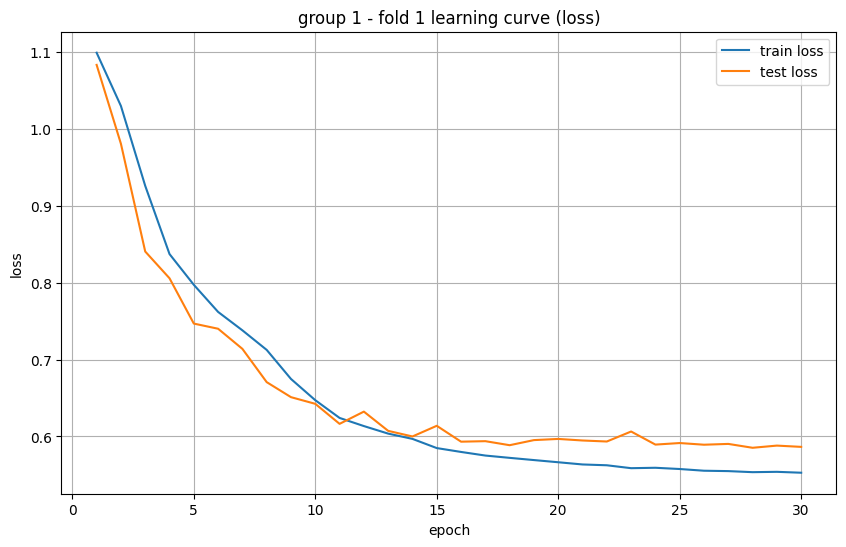

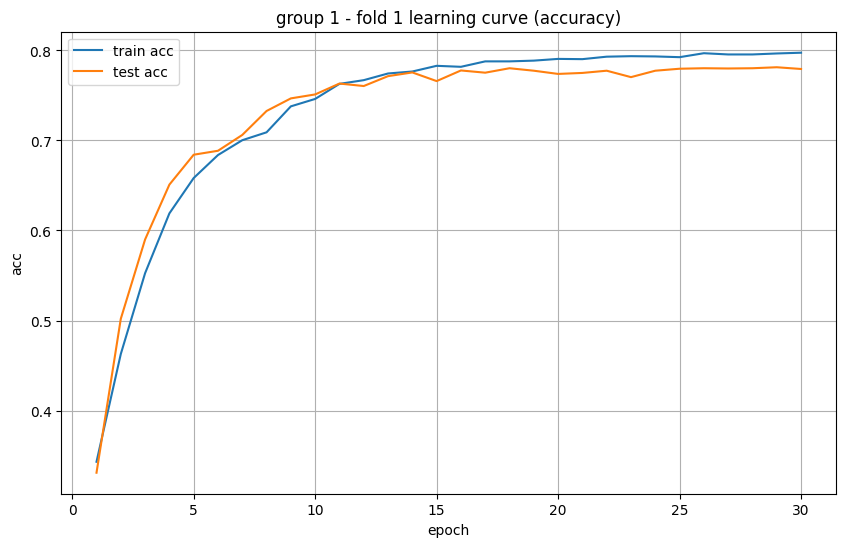

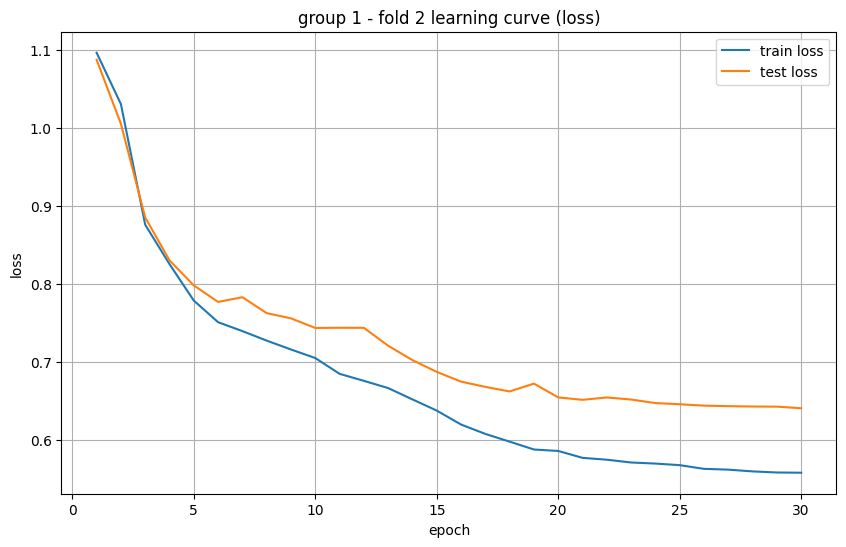

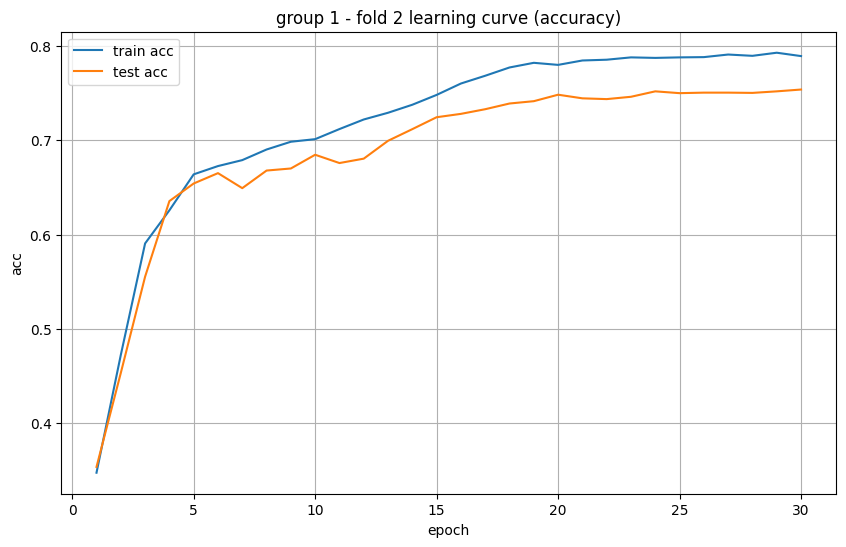

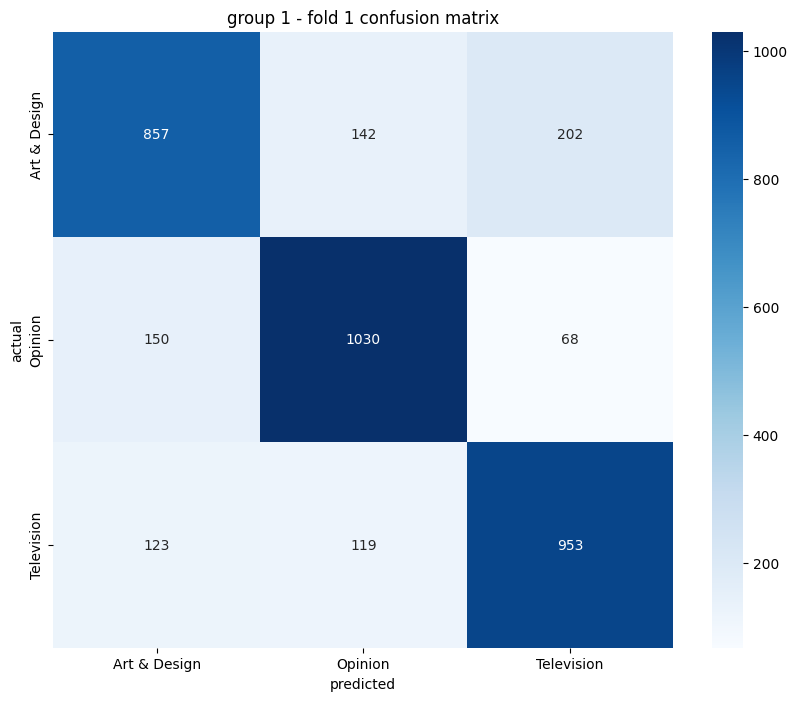

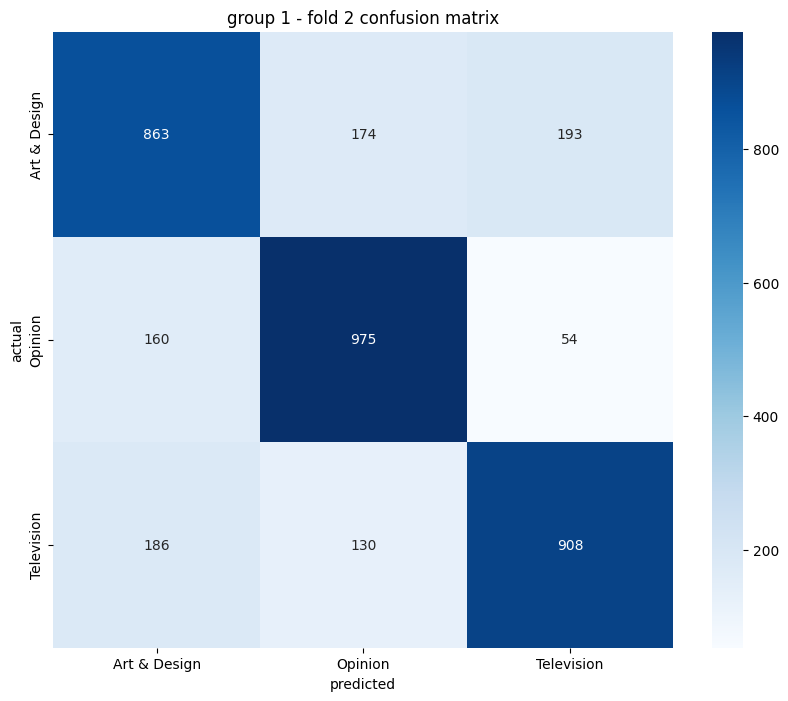


group 2 처리 중...

  fold 1/2 처리 중...
    epoch 1/30: train loss: 1.1013, train acc: 0.3295
                               test loss: 1.0992, test acc: 0.3300
    epoch 5/30: train loss: 0.8973, train acc: 0.5869
                               test loss: 0.8859, test acc: 0.5940
    epoch 10/30: train loss: 0.8143, train acc: 0.6501
                               test loss: 0.8412, test acc: 0.6272
    epoch 15/30: train loss: 0.7606, train acc: 0.6824
                               test loss: 0.8060, test acc: 0.6570
    epoch 20/30: train loss: 0.7191, train acc: 0.7114
                               test loss: 0.7891, test acc: 0.6766
    epoch 25/30: train loss: 0.6992, train acc: 0.7216
                               test loss: 0.7741, test acc: 0.6838
    epoch 30/30: train loss: 0.6845, train acc: 0.7274
                               test loss: 0.7695, test acc: 0.6863

  fold 2/2 처리 중...
    epoch 1/30: train loss: 1.1019, train acc: 0.3140
                               test l

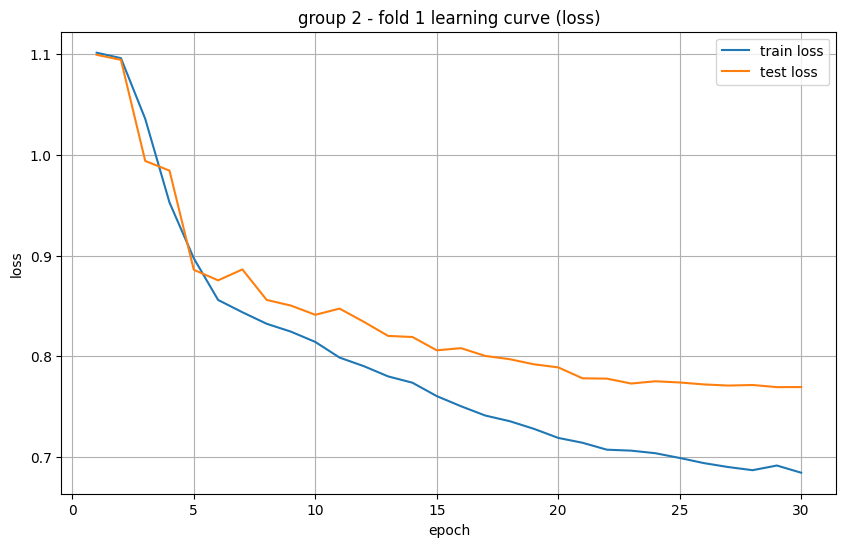

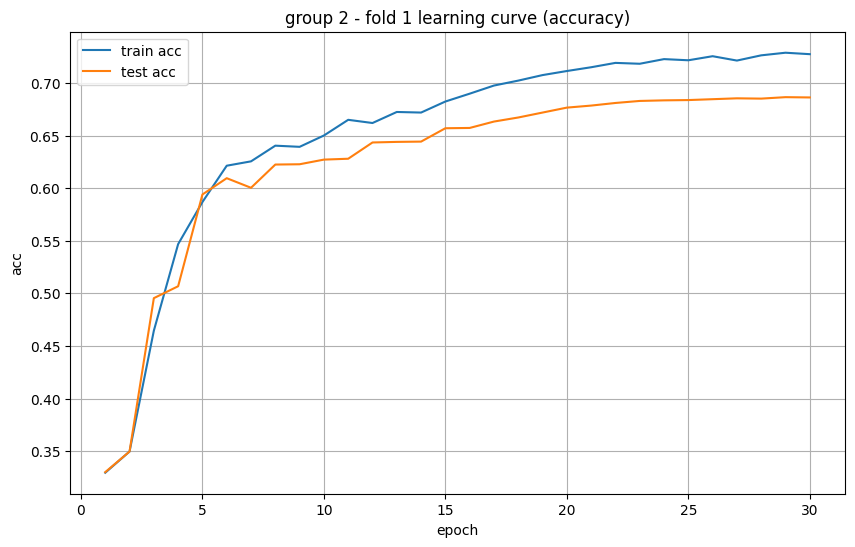

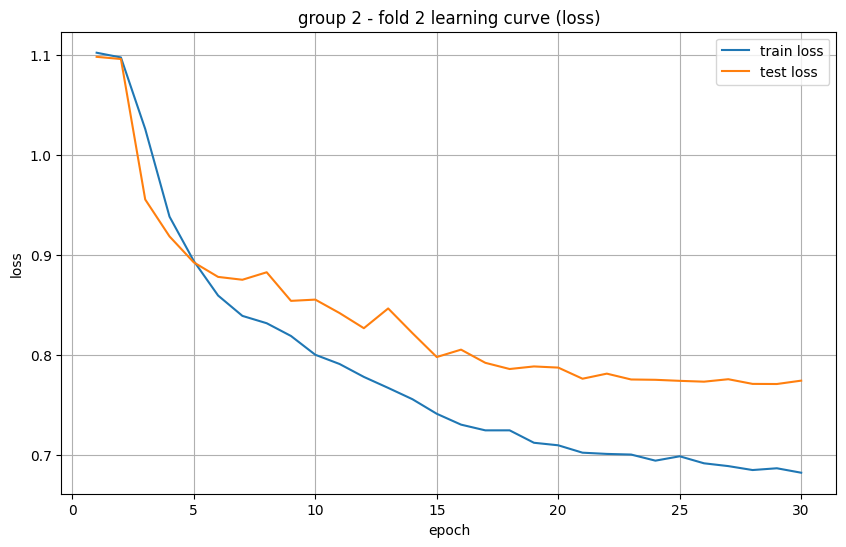

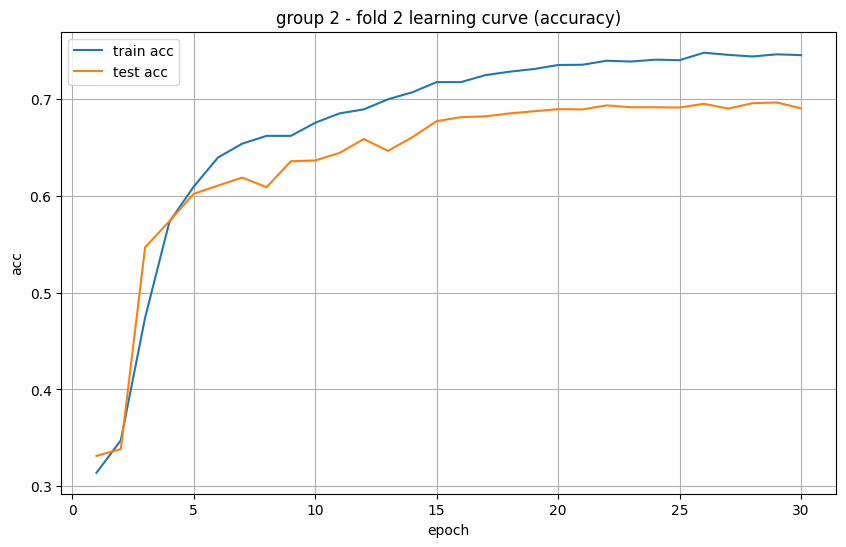

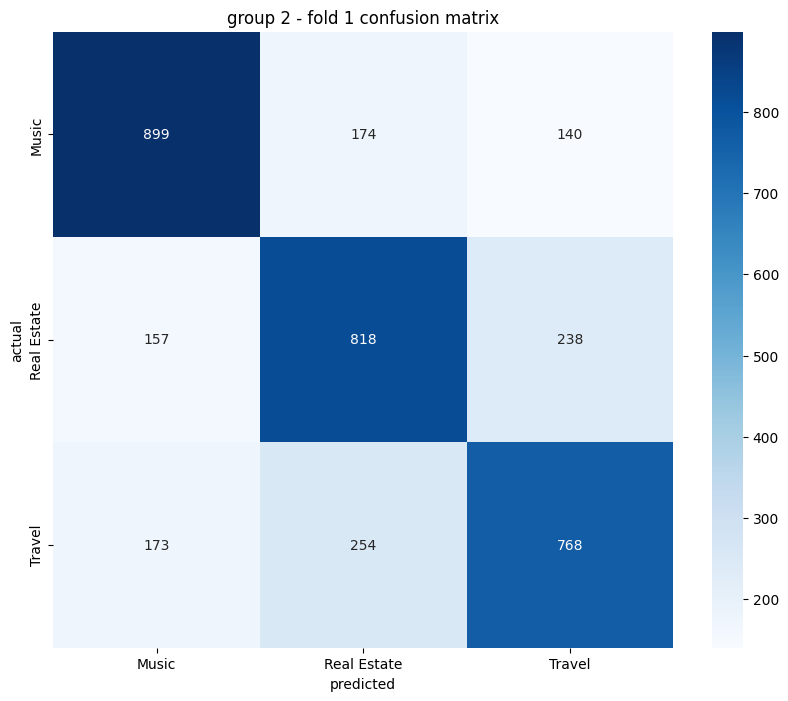

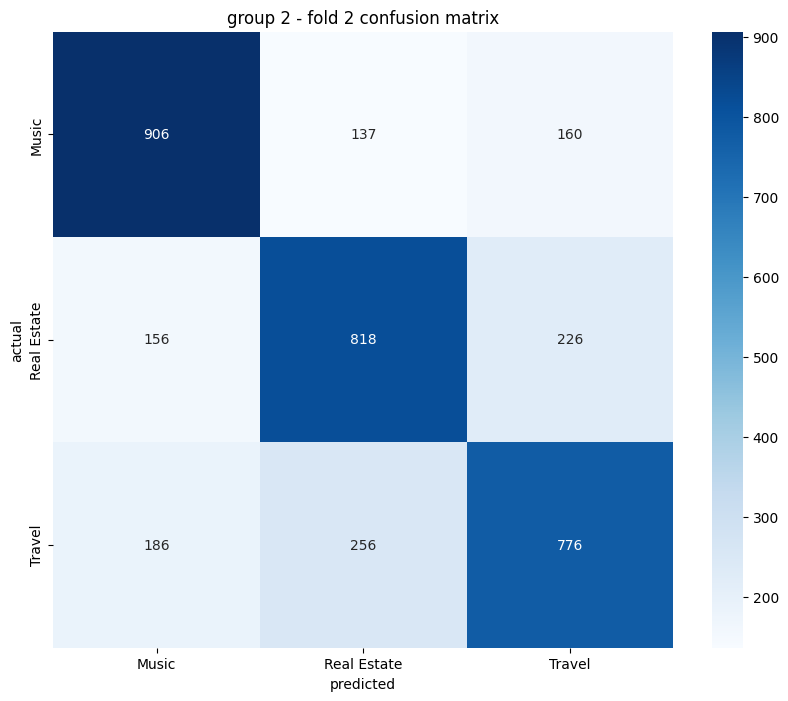


group 3 처리 중...

  fold 1/2 처리 중...
    epoch 1/30: train loss: 1.1006, train acc: 0.3563
                               test loss: 1.0988, test acc: 0.3367
    epoch 5/30: train loss: 0.9362, train acc: 0.5721
                               test loss: 0.8459, test acc: 0.6456
    epoch 10/30: train loss: 0.6931, train acc: 0.7214
                               test loss: 0.7192, test acc: 0.7245
    epoch 15/30: train loss: 0.6519, train acc: 0.7458
                               test loss: 0.6837, test acc: 0.7361
    epoch 20/30: train loss: 0.6240, train acc: 0.7568
                               test loss: 0.6678, test acc: 0.7408
    epoch 25/30: train loss: 0.6021, train acc: 0.7660
                               test loss: 0.6552, test acc: 0.7411
    epoch 30/30: train loss: 0.5921, train acc: 0.7737
                               test loss: 0.6511, test acc: 0.7425

  fold 2/2 처리 중...
    epoch 1/30: train loss: 1.1008, train acc: 0.3485
                               test l

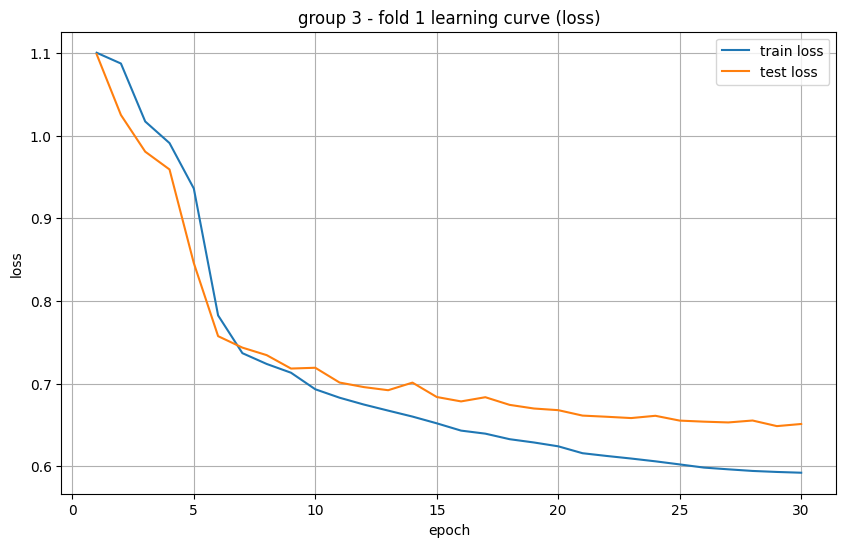

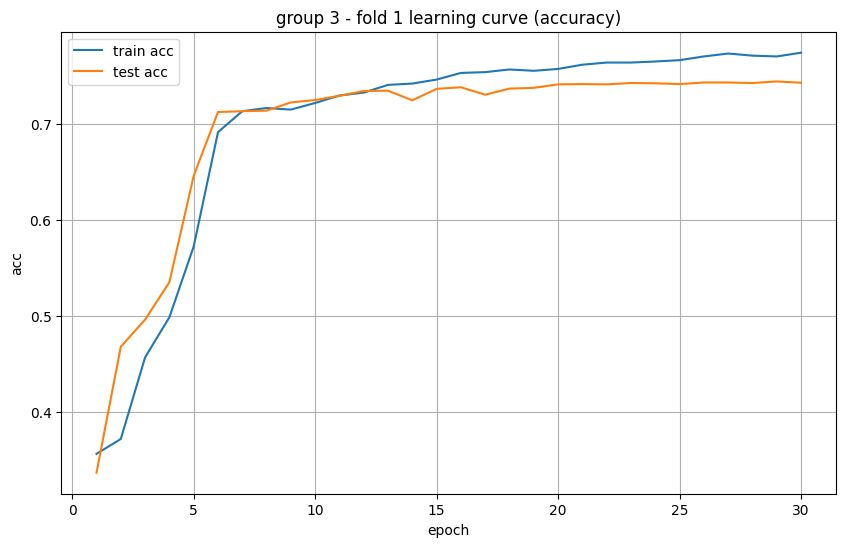

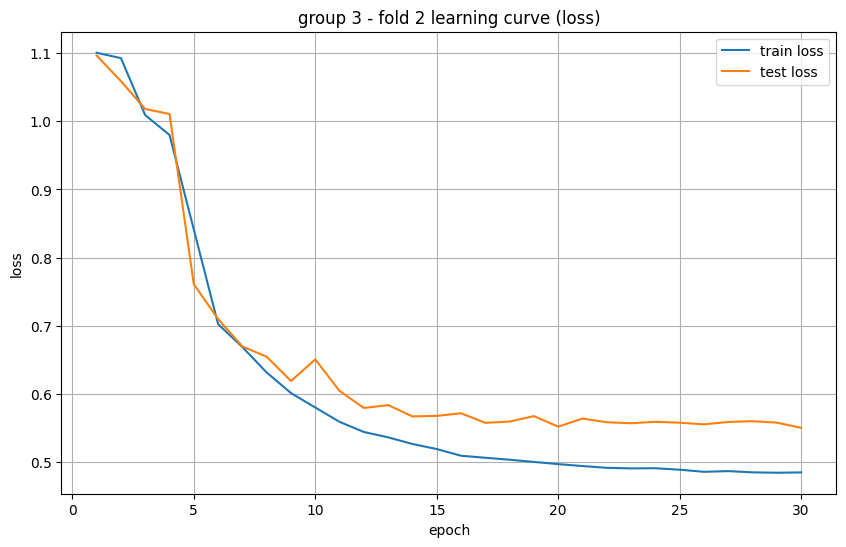

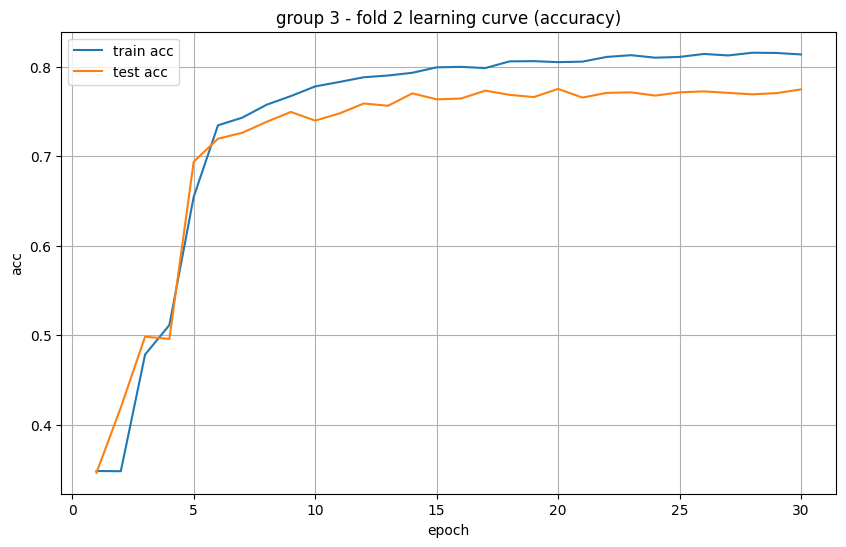

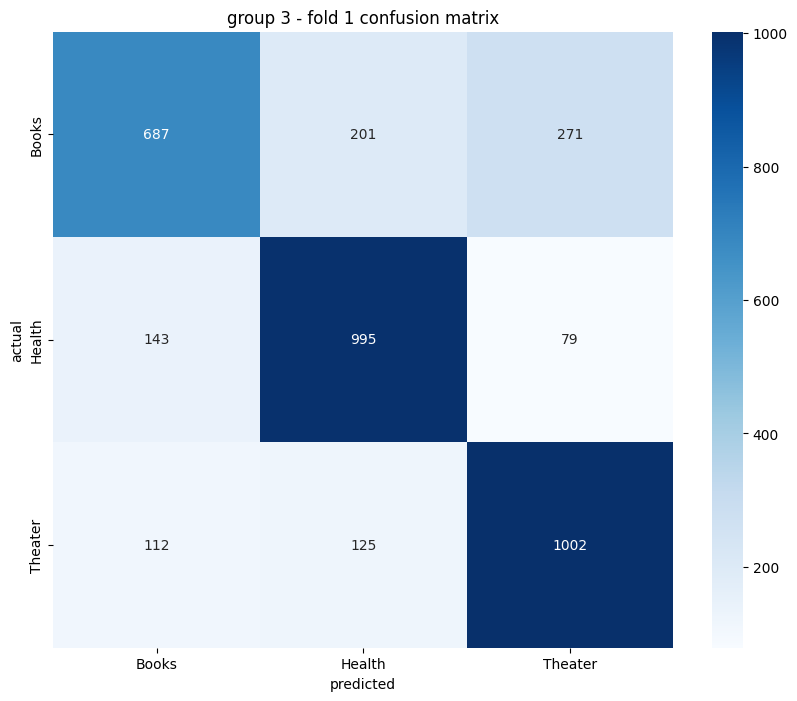

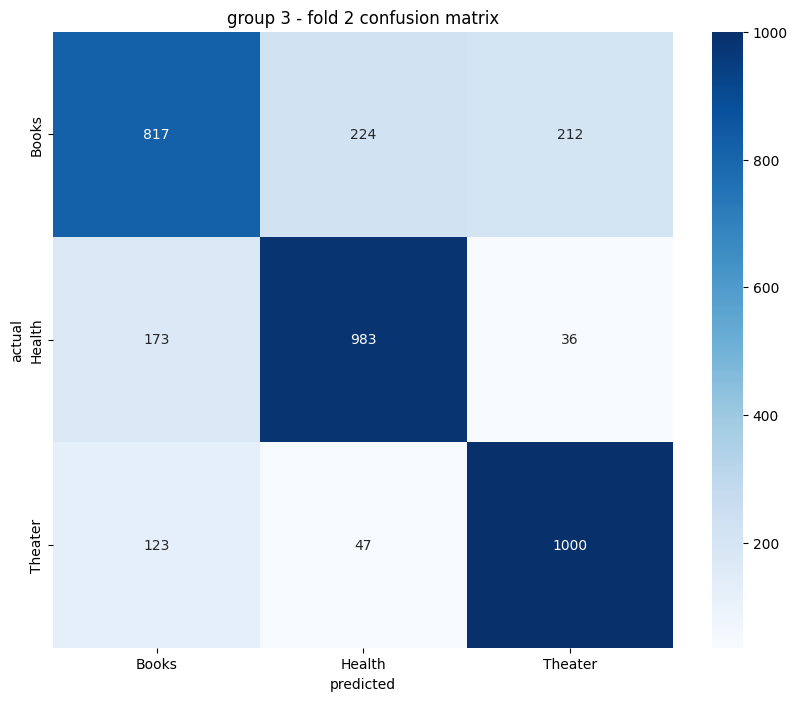


group 4 처리 중...

  fold 1/2 처리 중...
    epoch 1/30: train loss: 1.0994, train acc: 0.3541
                               test loss: 1.1017, test acc: 0.3223
    epoch 5/30: train loss: 0.9751, train acc: 0.4837
                               test loss: 1.0271, test acc: 0.4457
    epoch 10/30: train loss: 0.9148, train acc: 0.5336
                               test loss: 0.9775, test acc: 0.4880
    epoch 15/30: train loss: 0.8255, train acc: 0.6202
                               test loss: 0.8893, test acc: 0.5669
    epoch 20/30: train loss: 0.7907, train acc: 0.6495
                               test loss: 0.8883, test acc: 0.5733
    epoch 25/30: train loss: 0.7739, train acc: 0.6548
                               test loss: 0.8857, test acc: 0.5791
    epoch 30/30: train loss: 0.7688, train acc: 0.6590
                               test loss: 0.8697, test acc: 0.5911

  fold 2/2 처리 중...
    epoch 1/30: train loss: 1.1014, train acc: 0.3273
                               test l

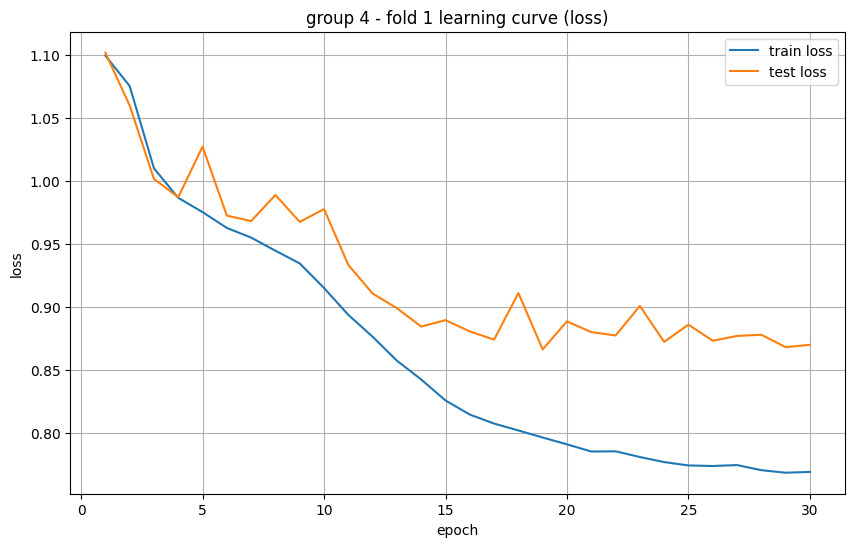

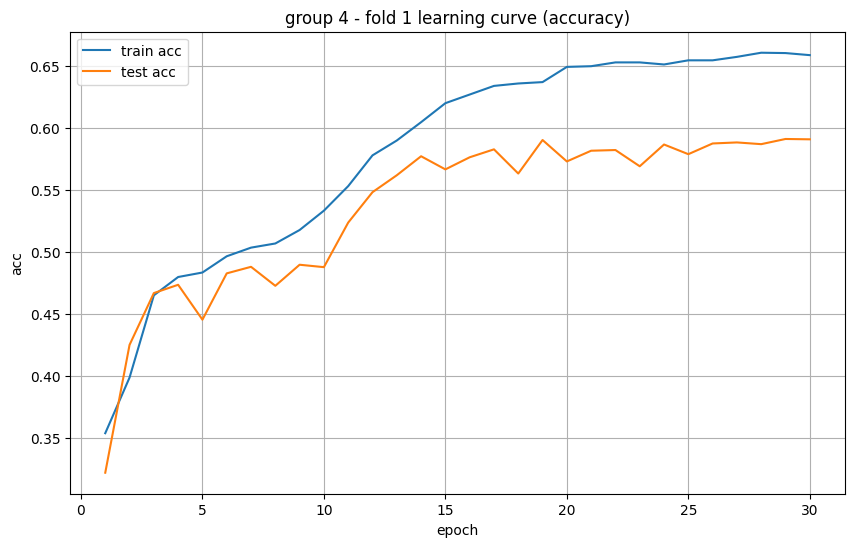

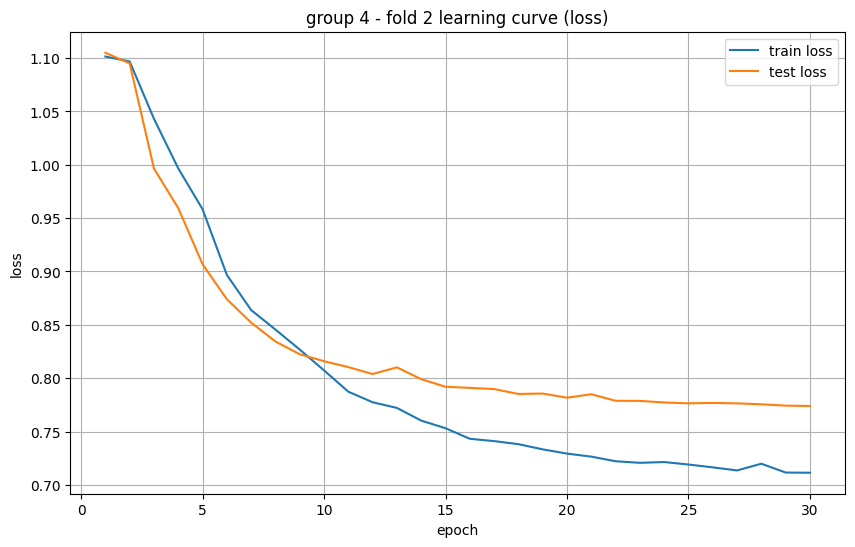

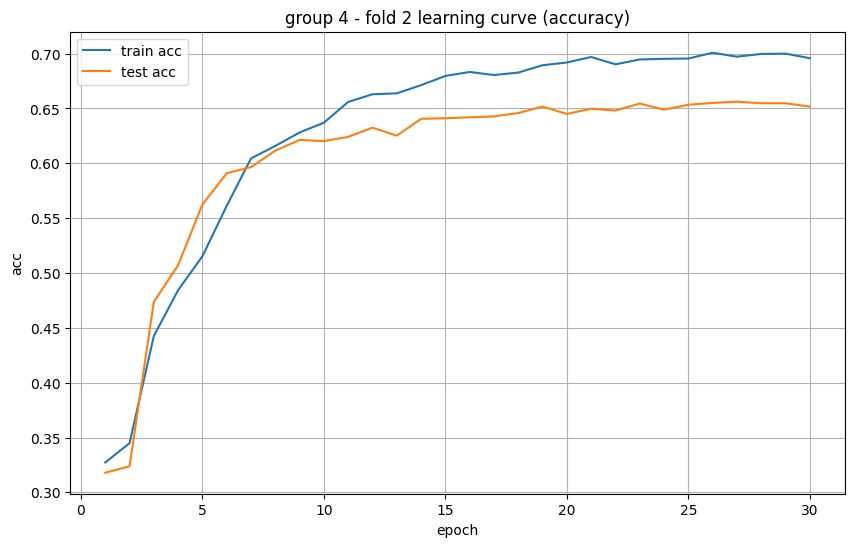

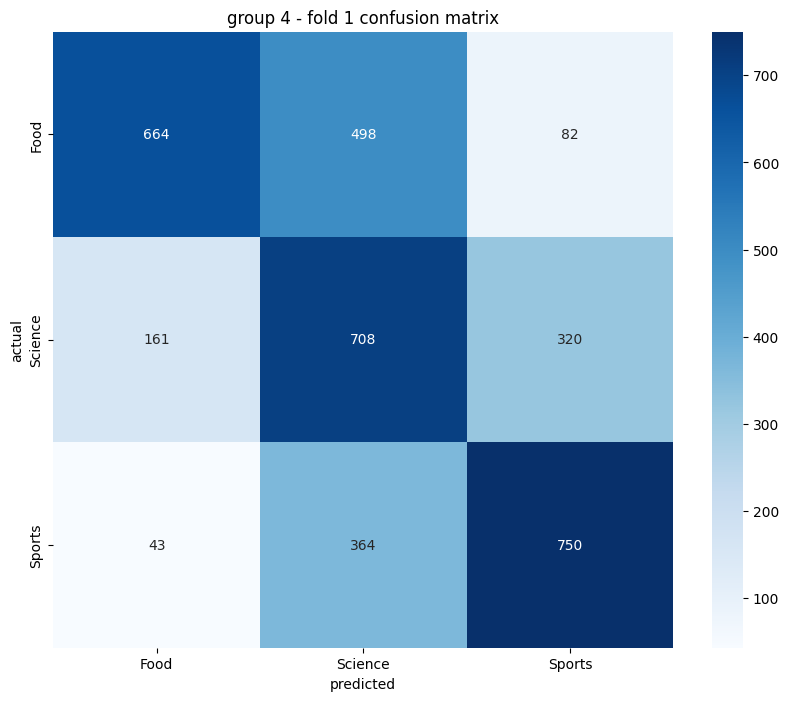

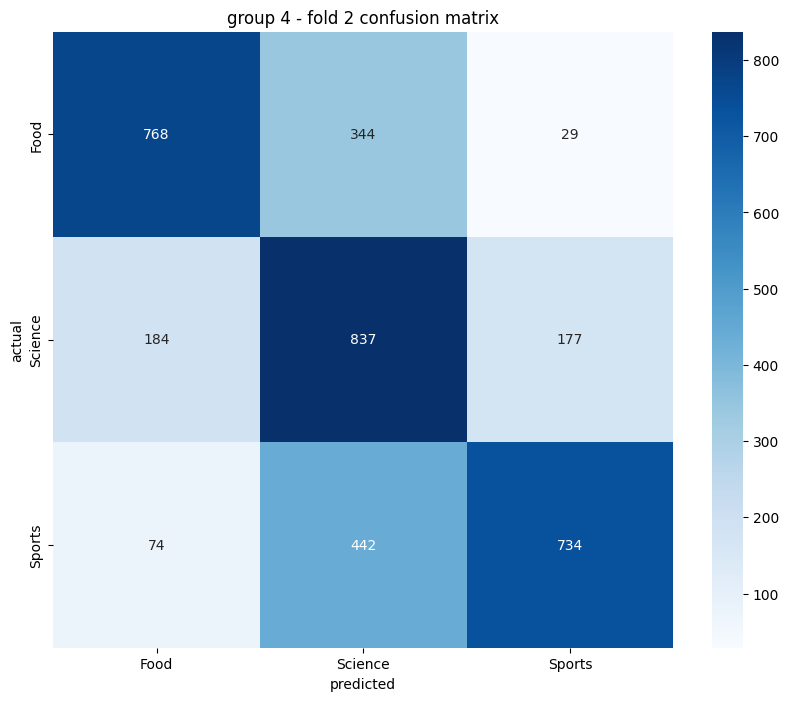


group 5 처리 중...

  fold 1/2 처리 중...
    epoch 1/30: train loss: 1.1021, train acc: 0.3393
                               test loss: 1.0999, test acc: 0.3308
    epoch 5/30: train loss: 0.8700, train acc: 0.5871
                               test loss: 0.8189, test acc: 0.6384
    epoch 10/30: train loss: 0.5645, train acc: 0.7937
                               test loss: 0.6249, test acc: 0.7604
    epoch 15/30: train loss: 0.5235, train acc: 0.8080
                               test loss: 0.6155, test acc: 0.7596
    epoch 20/30: train loss: 0.5085, train acc: 0.8189
                               test loss: 0.6151, test acc: 0.7666
    epoch 25/30: train loss: 0.4994, train acc: 0.8222
                               test loss: 0.6120, test acc: 0.7680
    epoch 30/30: train loss: 0.4949, train acc: 0.8264
                               test loss: 0.6131, test acc: 0.7660

  fold 2/2 처리 중...
    epoch 1/30: train loss: 1.1004, train acc: 0.3300
                               test l

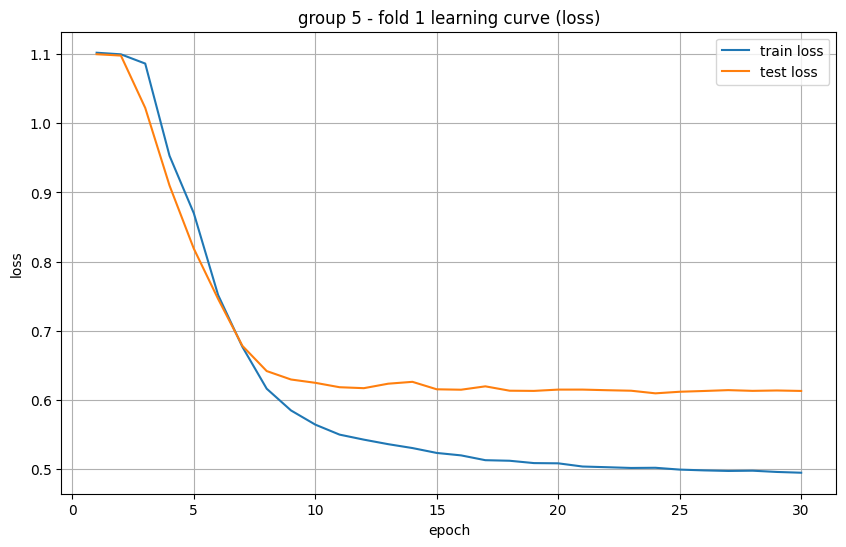

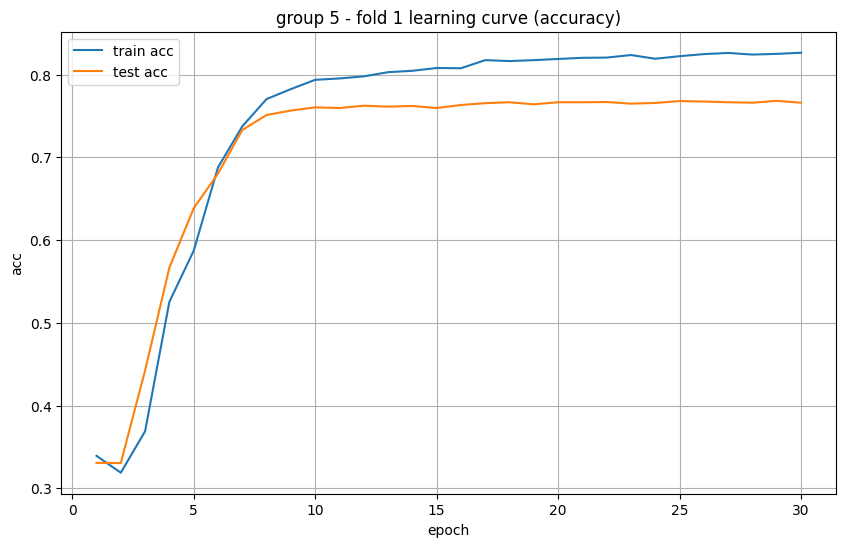

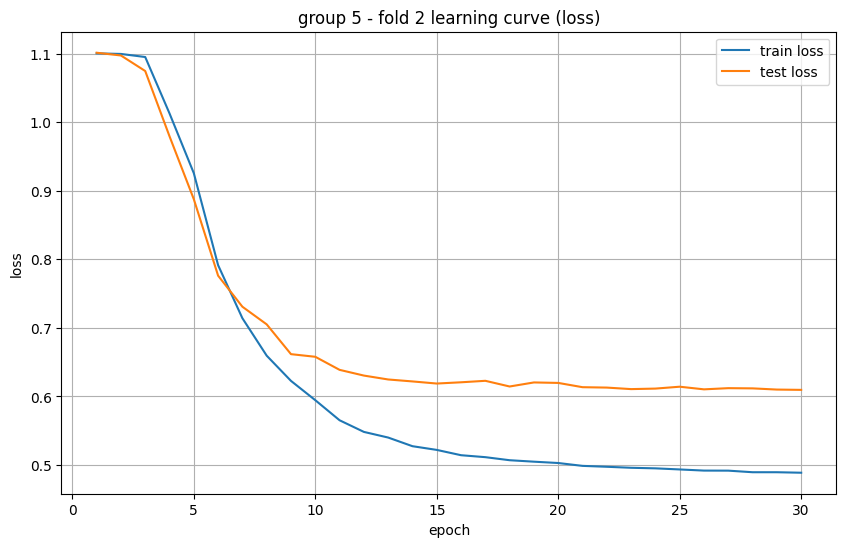

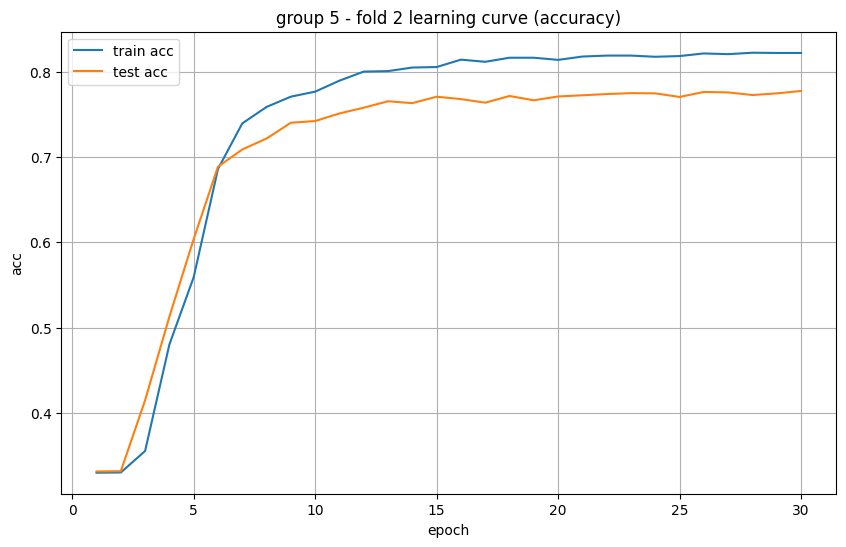

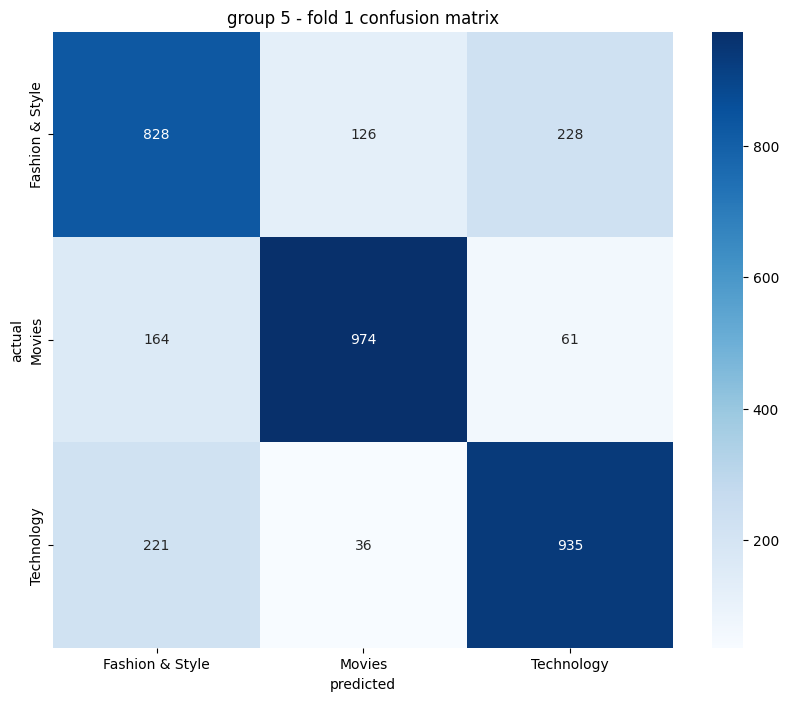

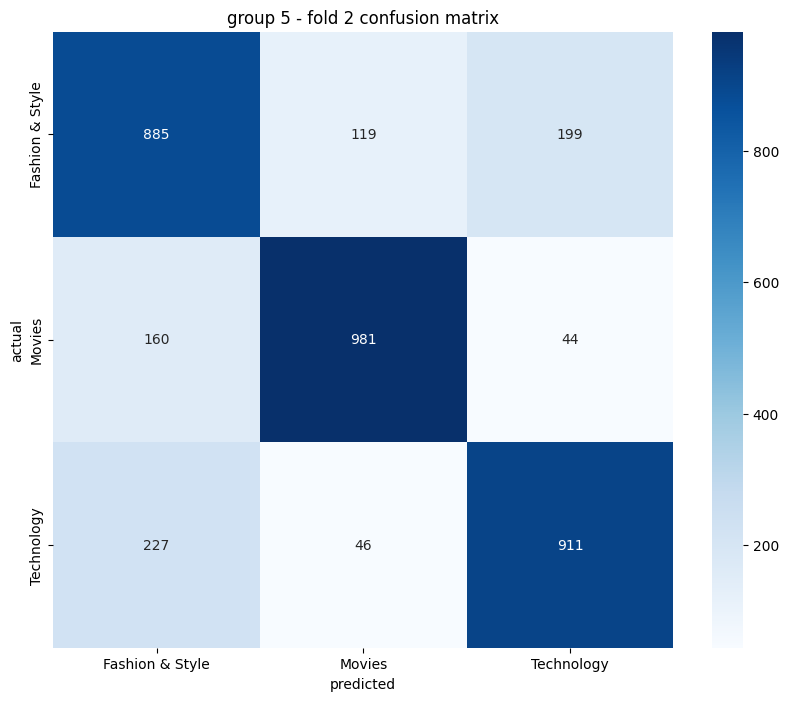


group 6 처리 중...

  fold 1/2 처리 중...
    epoch 1/30: train loss: 1.1014, train acc: 0.3419
                               test loss: 1.0982, test acc: 0.3421
    epoch 5/30: train loss: 0.9482, train acc: 0.5595
                               test loss: 0.9529, test acc: 0.5707
    epoch 10/30: train loss: 0.9030, train acc: 0.6093
                               test loss: 0.9278, test acc: 0.5980
    epoch 15/30: train loss: 0.8772, train acc: 0.6328
                               test loss: 0.9142, test acc: 0.6067
    epoch 20/30: train loss: 0.8624, train acc: 0.6421
                               test loss: 0.9058, test acc: 0.6129
    epoch 25/30: train loss: 0.8547, train acc: 0.6474
                               test loss: 0.9046, test acc: 0.6149
    epoch 30/30: train loss: 0.8513, train acc: 0.6494
                               test loss: 0.9022, test acc: 0.6155

  fold 2/2 처리 중...
    epoch 1/30: train loss: 1.0993, train acc: 0.3514
                               test l

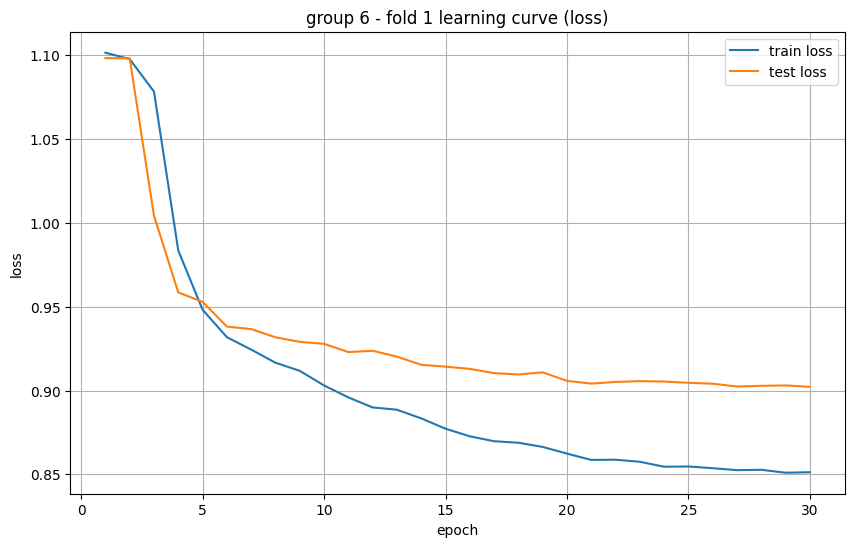

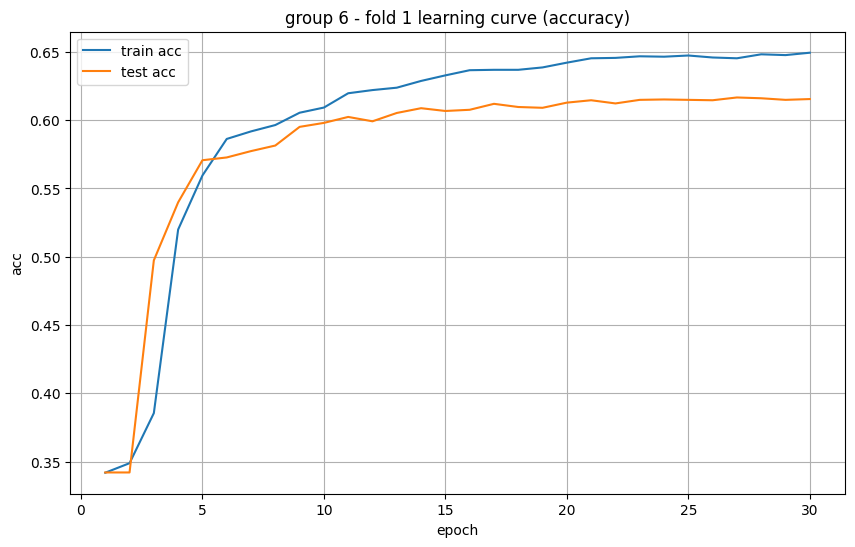

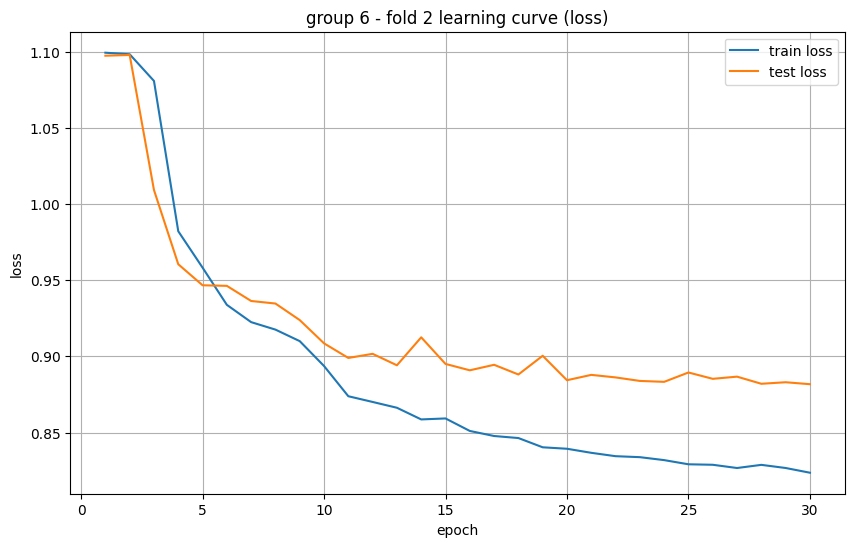

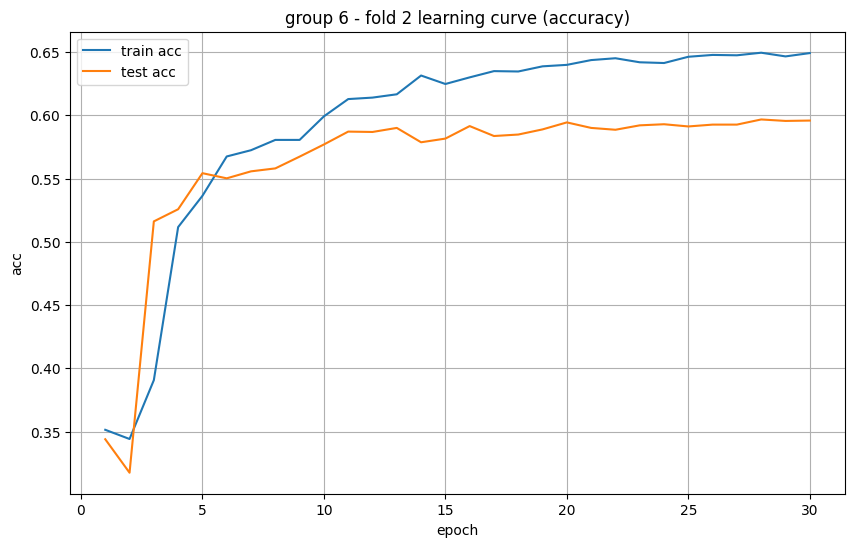

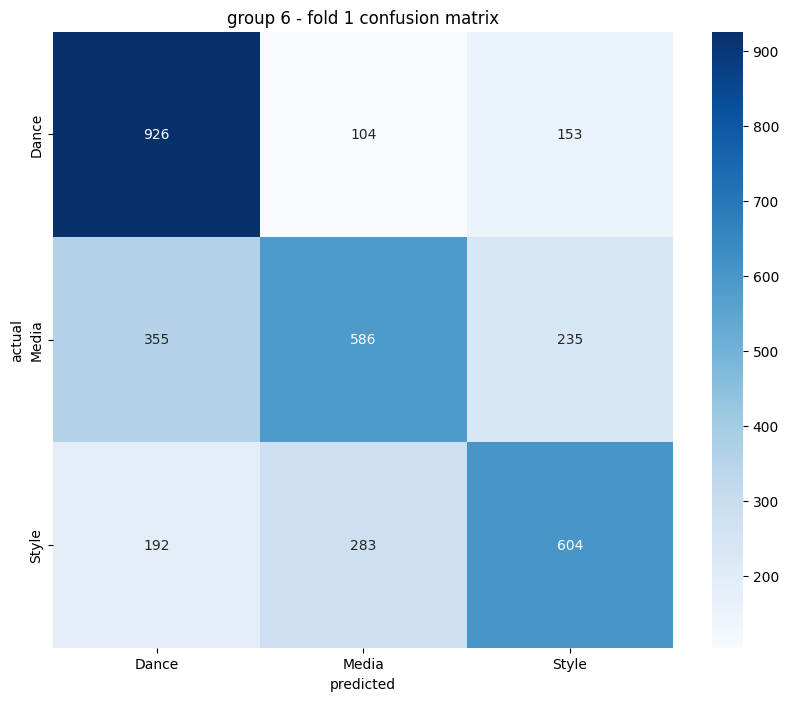

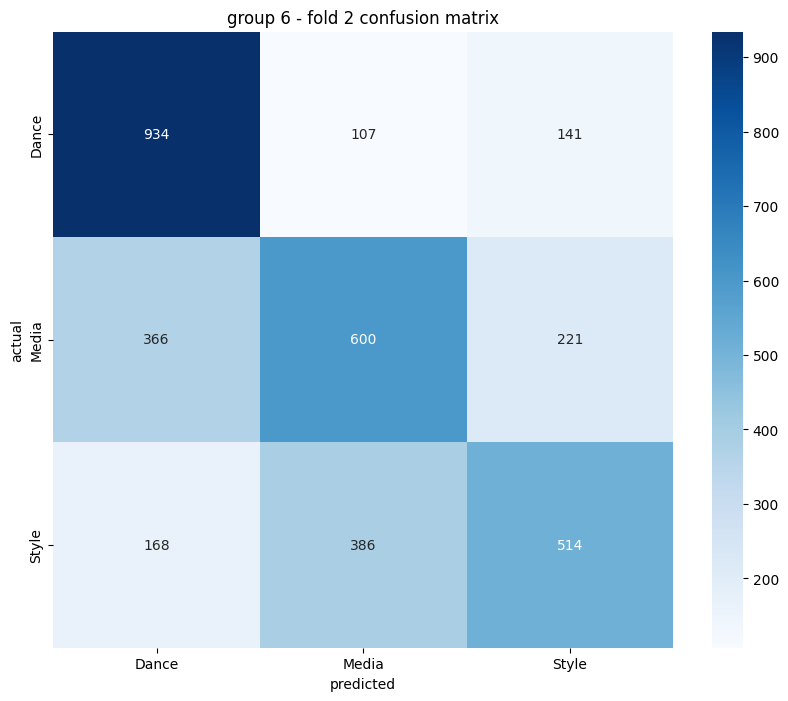


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.7666
  폴드 1: 테스트 정확도 = 0.7794
  폴드 2: 테스트 정확도 = 0.7538

그룹 2 - 평균 테스트 정확도: 0.6883
  폴드 1: 테스트 정확도 = 0.6863
  폴드 2: 테스트 정확도 = 0.6904

그룹 3 - 평균 테스트 정확도: 0.7585
  폴드 1: 테스트 정확도 = 0.7425
  폴드 2: 테스트 정확도 = 0.7746

그룹 4 - 평균 테스트 정확도: 0.6214
  폴드 1: 테스트 정확도 = 0.5911
  폴드 2: 테스트 정확도 = 0.6517

그룹 5 - 평균 테스트 정확도: 0.7717
  폴드 1: 테스트 정확도 = 0.7660
  폴드 2: 테스트 정확도 = 0.7774

그룹 6 - 평균 테스트 정확도: 0.6057
  폴드 1: 테스트 정확도 = 0.6155
  폴드 2: 테스트 정확도 = 0.5959


In [8]:
EPOCHS = 30
BATCH_SIZE = 32
K_FOLDS = 2
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수
LR = 1e-4

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    # val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    # with open(val_loader_save_path, 'wb') as f:
    #     pickle.dump(best_valid_loader, f) 
    # print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")

In [9]:
import pickle

file_path = "/home/youlee/perceiver/perceiver/loader/text_val_loader_1.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

type_of_data = type(data)
if hasattr(data, 'shape'):
    data_shape = data.shape
else:
    try:
        data_shape = (len(data), len(data[0]))
    except Exception as e:
        data_shape = f"Cannot determine shape: {e}"

type_of_data, data_shape


(torch.utils.data.dataloader.DataLoader,
 "Cannot determine shape: 'DataLoader' object is not subscriptable")

In [10]:
for batch in data:
  
    if isinstance(batch, dict):
        print({key: value.shape for key, value in batch.items()})

    elif isinstance(batch, tuple):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")
    break  

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
